In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd, numpy as np, seaborn as sn
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sn.set_context('notebook')

# Spatial interpolation of Scandinavian point data

Leah has some point data covering Scandinavia which she'd like to interpolate onto a regular grid. The data are concentration measurments in lakes. Such values will be difficult to interpolate in a meaningful way, but I'll try to present a few simple options here and these can be reviewed later if necessary.

## 1. Read the data

In [2]:
in_xls = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\ECCO_Spat_Interp\Nordic_data_GIS_Import.xlsx'

df = pd.read_excel(in_xls, sheetname='Nordic95_LakeChem_SiteProprties')

# Station ID 3249 has no lat/long info. Ignore for now.
df.dropna(how='any', inplace=True)

df.head()

,Station_ID,Lat,Long,UTM_N_m,UTM_E_m,UTM_Zone,Country,TOC,Cl,nmCaMg,SO4,nmSO4
0,9,59.00,11.56,6543000.0,647200.0,32.0,Norway,10.0,174.87,66.76,99.93,81.92
1,10,59.80,11.85,6633582.0,659961.0,32.0,Norway,11.7,53.59,81.82,62.45,56.94
2,11,60.05,12.44,6660800.0,357850.0,33.0,Norway,12.1,42.30,105.92,62.45,58.10
3,12,60.32,11.84,6691345.0,656890.0,32.0,Norway,8.0,28.20,43.08,56.21,53.30
4,13,60.59,12.51,6719830.0,364040.0,33.0,Norway,9.3,22.56,83.41,54.13,51.80


## 2. Co-ordinate transformations

The data span a variety of UTM zones. One option is to directly interpolate the latitude and longitude values (i.e. perform the interpolation in elipsoidal co-ordinates). This would probably work OK, but the output will be more difficult to interpret. Working in Cartesian co-ordinates seems more natural, but this requires choosing a suitable projected co-ordinate system and applying a transformation. It's not obvious which co-ordinate transformation to use, but [this post](http://gis.stackexchange.com/questions/50692/whats-the-best-projection-for-rasterization-of-random-latitude-and-longitude-da) suggests that a suitably shifted **Albers equal-area conic** projection could be appropriate.

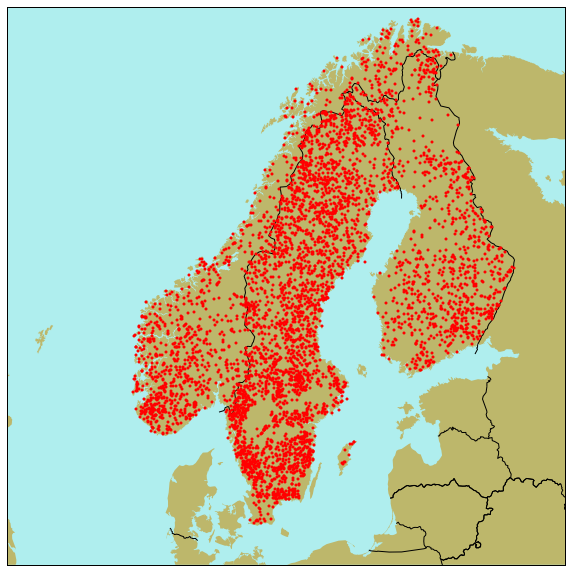

In [3]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Map (long, lat) to (x, y) for plotting
x, y = m(df['Long'].values, df['Lat'].values)

# Plot
plt.plot(x, y, 'or', markersize=3)

This looks reasonable, but it's a good idea to check the distortion introduced by this projection at this scale. Equal area projections preserve area, but not shape, and distortion becomes especially pronounced at high latitudes. This can be illustrated using [Tissot indicatrices](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix).

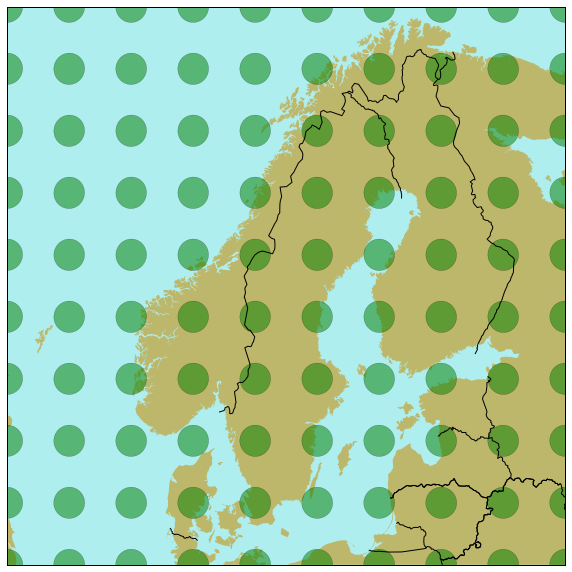

In [4]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Draw Tissot indicatrices to show distortion
for y in np.linspace(m.ymin/20, m.ymax, 10):
    for x in np.linspace(m.xmin, m.xmax, 10):
        lon, lat = m(x, y, inverse=True)
        poly = m.tissot(lon, lat,           # Location
                        0.5,                # Radius in degrees
                        100,                # N pts used to draw indicatrix
                        facecolor='green',
                        alpha=0.5)

All the indicatrices have the same area (this is a property of the specified projection). What's more, they all look pretty-much circular to me, which implies the distortion is fairly minimal within the region of interest. (As an example of more extreme distortion, see [this link](http://matplotlib.org/basemap/users/aea.html), which uses the same projection over a much greater area).

Overall, the above projection seems like a reasonable choice for interpolation.

## 3. Kriging

The example below shows Ordinary Kriging using just the default values. This should probably be checked and refined to make sure the assumptions are satisfied (e.g. it might be a good idea to log-transform the concentration values so they are approximately normally distributed). A few useful links:

  * [Kriging from scratch with Python](http://connor-johnson.com/2014/03/20/simple-kriging-in-python/)
  * [Interpolation with Python](http://stackoverflow.com/questions/24978052/interpolation-over-regular-grid-in-python)
  * [Krigin in R](http://gis.stackexchange.com/questions/158021/plotting-map-resulted-from-kriging-in-r)
  * [Kriging versus IDW](http://gis.stackexchange.com/questions/83470/when-to-use-idw-vs-kriging-interpolation-for-dem-creation/83471#83471)
  * [Interpolation in ArcGIS](http://web.mit.edu/course/1/1.966/www/Lab4/)
  * [More advanced kirging options using ArcGIS Geostatistical Analyst](https://www.hsph.harvard.edu/gis/arcgis-tips/kriging/)
  * [Spatial interpolation overview](http://personal.colby.edu/personal/m/mgimond/Spatial/Interpolation.html)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Sill: 31.8586090973
Range: 797202.09113
Nugget: 8.79311764606 



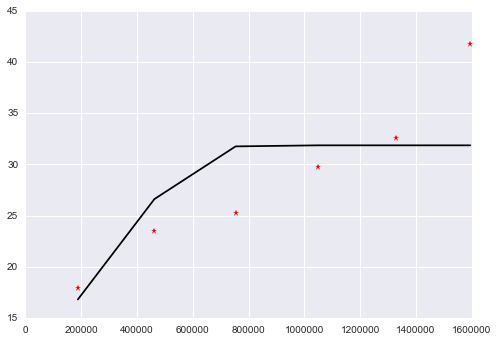

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [5]:
# Just work on a subset of data for testing
df2 = df.sample(n=500)

# Set up 1 km grid for interpolation
gridx = np.arange(m.xmin, m.xmax, 1000)
gridy = np.arange(m.ymin, m.ymax, 1000)

# Map (long, lat) to projected (x, y)
x, y = m(df2['Long'].values, df2['Lat'].values)

# Ordinary kriging with automatic fitting of variogram parameters
ord_krig = OrdinaryKriging(x,                # Projected x values from above
                           y,                # Projected y values from above
                           df2['TOC'].values, # Values to interpolate
                           variogram_model='spherical', # linear, power, gaussian, spherical or exponential
                           verbose=True,
                           enable_plotting=True)

# Creates the kriged grid and the variance grid. 
z, ss = ord_krig.execute('grid', # Treat gridx and gridy as defining rectangular grid
                         gridx, 
                         gridy,
                         backend='loop') # Slow, but less memory intensive

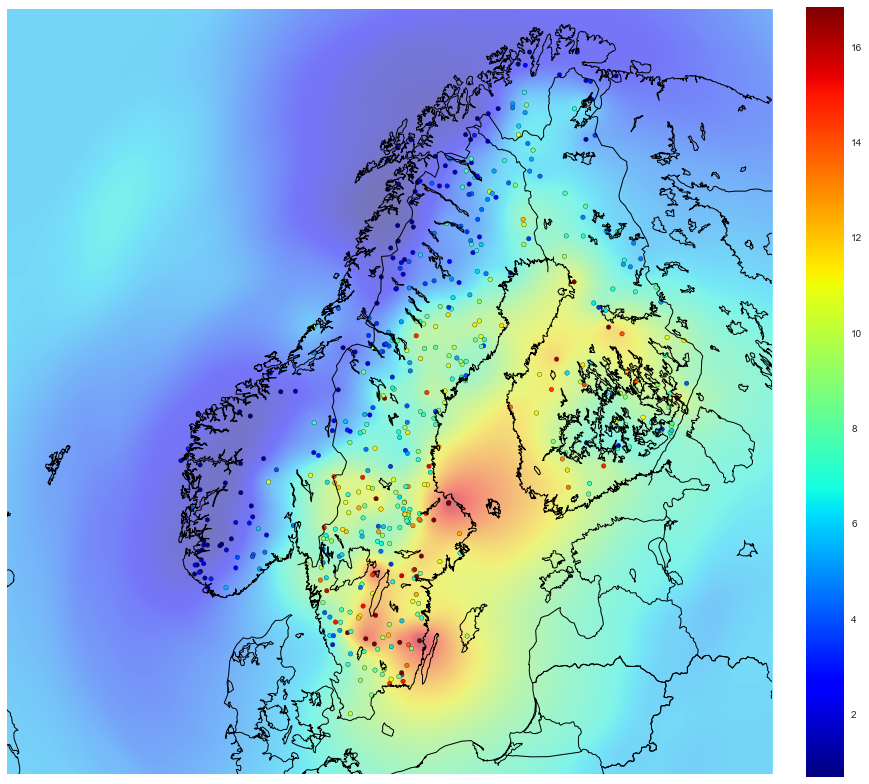

In [6]:
# Plot 
fig = plt.figure(figsize=(15, 15))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Add map components
m.imshow(z, cmap='jet', alpha=0.5)
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
plt.scatter(x, y, c=df2['TOC'].values, cmap='jet', vmin=z.min(), vmax=z.max())
plt.colorbar(fraction=0.046, pad=0.04)

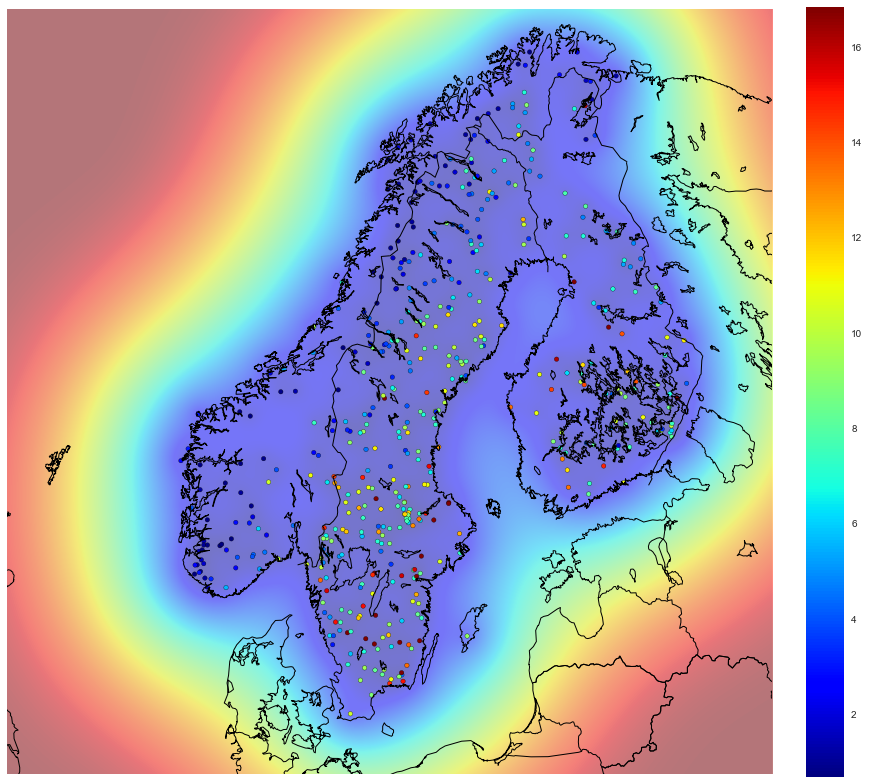

In [7]:
# Plot 
fig = plt.figure(figsize=(15, 15))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Add map components
m.imshow(ss, cmap='jet', alpha=0.5)
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
plt.scatter(x, y, c=df2['TOC'].values, cmap='jet', vmin=z.min(), vmax=z.max())
plt.colorbar(fraction=0.046, pad=0.04)

### 3.1. Kriging issues

This all sems to work pretty well, but the "proper" kriging algorithm implemented by PyKrige is difficult to apply to large datasets due to memory issues. Therefore, although the approach above might work, it will take *ages* to process the 5000 or so points in the full dataset. 

## 4. ArcGIS

The ArcGIS version of kriging includes some fudges to speed things up. The algorithm is therefore not as rigorous, but it is faster. The first step is to reproject the data for use in ArcGIS. One way is to define an entirely custom co-ordinate system from scratch (as we did above), but from a quick skim it looks as though ArcGIS already has an Albers equal-area projection for Europe with the following parameters:

    Central point (lat, long): 30, 10
    Standard parallel 1:       43
    Standard parallel 2:       62

This isn't massively different to what we specified above, so perhaps we can just use this directly? To check, plot the Tissot indicatrices:

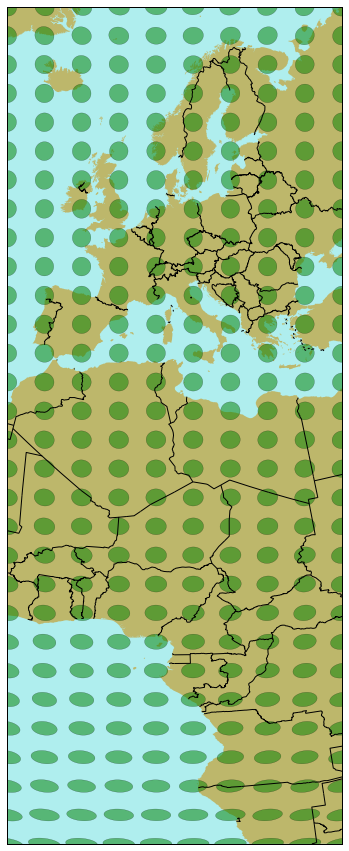

In [8]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 15))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=4000000,
            height=10000000,
            resolution='i',
            lat_1=43,          # 1st standard parallel
            lat_2=62,          # 2st standard parallel
            lon_0=10,lat_0=30) # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Draw Tissot indicatrices to show distortion
for y in np.linspace(m.ymin/20, m.ymax, 30):
    for x in np.linspace(m.xmin, m.xmax, 10):
        lon, lat = m(x, y, inverse=True)
        poly = m.tissot(lon, lat,           # Location
                        1,                # Radius in degrees
                        100,                # N pts used to draw indicatrix
                        facecolor='green',
                        alpha=0.5)

It's clear there is some distortion in northern Scandinavia, but it's not especially extreme. For now, I'd recommend just using this - we can always define a custom projection later if necessary (as above). In ArcGIS, this projection is called `Europe_Albers_Equal_Area_Conic` and it's located in `Projected co-ordinate systems > Continental > Europe`.

## 5. Other interpolation options

SciPy appears to offer some other potentially useful interpolation algorithms. These are explored below.

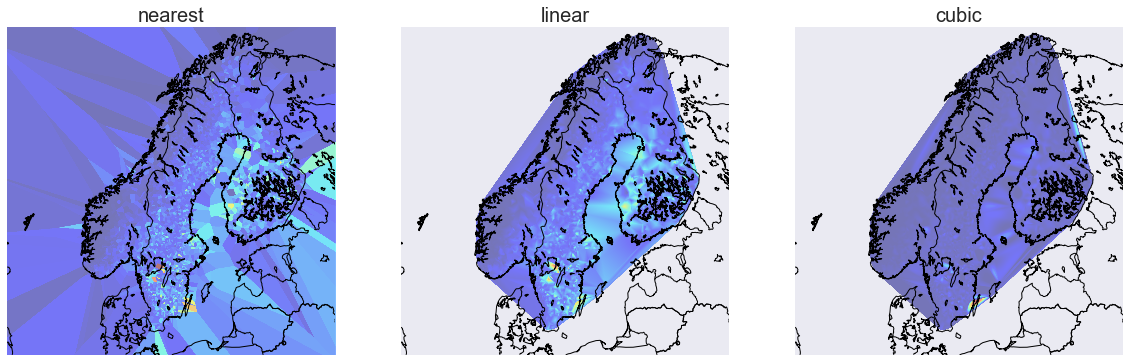

In [5]:
from scipy.interpolate import griddata

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Set up 1 km grid for interpolation
gridx = np.arange(m.xmin, m.xmax, 1000)
gridy = np.arange(m.ymin, m.ymax, 1000)

# Map (long, lat) to projected (x, y)
x, y = m(df['Long'].values, df['Lat'].values)

# Reformat to synatx required for griddata func
pts = np.array(zip(x ,y))
vals = df['TOC'].values

# Grid to interpolate
xx, yy = np.meshgrid(gridx, gridy)

# Plot
fig = plt.figure(figsize=(20, 10))

# Loop over methods
for idx, meth in enumerate(['nearest', 'linear', 'cubic']):
    ax = fig.add_subplot(1, 3, idx+1)
    grid = griddata(pts, vals, (xx, yy), method=meth)
    ax.set_title(meth, fontsize=20)
    m.imshow(grid, cmap='jet', alpha=0.5, vmin=0)
    m.drawcoastlines(linewidth=1)
    m.drawcountries(linewidth=1)

These approaches work, but clearly need some tweaking as they're predicting "spikes" and "troughs" which cause compression of the colour scale. Perhaps worth further investigation...?